# Import

In [1]:
from typing import Any, Union, Callable, List
from scipy.stats import norm
import os.path as osp
from abc import ABC, abstractmethod
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = False

In [2]:
sns.set()

# Abstract class.

### parameters.

In [3]:
# Parametres principaux
K = 1.0        # strike
T = 1.0        # echeance
r = 1.0        # taux de l'actif sans risque
sigma = 2.0    # volatilite du sous-jacent

# Parametres principaux
K = 100.        # strike
T = 1.        # echeance
r = .1        # taux de l'actif sans risque
sigma = .2    # volatilite du sous-jacent
s_0 = 100.


# Parametres de discretisation

N = 70         # pas dans le maillage en space
J = 300        # pas dans le maillage en temps

# N = 200         # pas dans le maillage en space
# J = 10_000        # pas dans le maillage en temps


# essayer avec N = 10, J = 225 ou J = 220 pour apprecier la stabilite

x_ = 5.  # bord du domaine coupe


EPS = 1e-5


# fonction du payoff
def g(x):
    a = -1. - x
    return a.clip(0)


def fun_k(t, x):
    a = -((T-t)/T)*np.exp(-r*t)
    b = -1 + (1/(T*r))*(1-np.exp(-r*t))
    return a*x+b

In [5]:
class EDPSolver(ABC):

    def __init__(self,
                 T: float,
                 r: float,
                 sigma: float,
                 N: int,
                 J: int,
                 x_min: float,
                 x_: float,
                 g: Callable,
                 name_g: str,
                 name_method: str,
                 path_to_dir_fig: str,
                 s_0: float = 100.
                 ) -> None:

        self.path_to_fig = osp.join(path_to_dir_fig, name_method + '_' + str(K) + '_' + str(T) + '_' + str(
            r) + '_' + str(sigma) + '_' + str(N) + '_' + str(J) + '_' + str(x_) + '_' + str(name_g) + '.png')

        self.T = T
        self.r = r
        self.sigma = sigma
        self.N = N
        self.J = J
        self.x_min = x_min
        self.x_ = x_
        self.g = g
        self.name_method = name_method
        self.s_0 = s_0

        # point du maillage en espace, endpoint = False parce que l'on sait deja
        self.x = np.linspace(x_min, x_, N, endpoint=False)
        # que dans le dernier point x_(N+1) = bar_x la solution approchee vaut 0

        self.h = self.x[1] - self.x[0]
        self.k = T / J

    @abstractmethod
    def mat_A(self, coeff) -> np.ndarray:
        pass

    @abstractmethod
    def mat_B(self, coeff) -> np.ndarray:
        pass

    @abstractmethod
    def __call__(self) -> Any:
        pass

In [13]:
class Linearized(EDPSolver):

    def step(self, B, Uj, U0) -> Any:
        raise NotImplementedError

    def __call__(self, plot: bool = True):

        # condition initiale (payoff de l'option)
        U0 = g(self.x)

        # Methode numerique

        Uj = U0

        plt.figure(figsize=(12, 9))

        for j in range(J):

            Uj[0] = fun_k((j+1)*self.k, self.x_min)

            coeff = ((1.+self.x)/(self.T-j*self.k + EPS))+self.r*self.x
            B = self.mat_B(coeff)
            Uj = self.step(B, Uj, U0)

            # visualisation de la solution approchee
            if (j + 1) % 2 == 0 and plot:
                plt.plot(self.x, self.s_0 * Uj, color='blue',
                         linestyle='dashed', linewidth=1)

        Uj[0] = fun_k((j+1)*self.k, self.x_min)
        Uj = Uj

        if plot:
            # reglages de la visualisation

            valin,  = plt.plot(self.x, self.s_0 * U0,
                               color='orange', linestyle='solid', linewidth=2)
            valfin, = plt.plot(self.x, self.s_0 * Uj,
                               color='blue', linestyle='solid', linewidth=2)

            plt.xlabel(
                r"Transformation de l'actif sous-jacent: $- \frac{A}{S}$")
            plt.ylabel("Valeur de l'option")

            # plt.xlim((-3. ,0.))
            plt.xlim((-1.1, -.9))
            plt.ylim((-0.15, 10.))

            plt.legend([valin, valfin], [
                       "Valeur à l'écheance", "Valeur (approx)"])

            plt.title(self.name_method)
            plt.savefig(self.path_to_fig)

        # the value of x at t=0 is -1
        value_of_interest = -1
        difference_array = np.absolute(self.x - value_of_interest)
        index = difference_array.argmin()

        return self.s_0 * Uj[index]

## Sub-classes of Linearized: LinearizedEuropean and LinearizedAmerican.

In [14]:
class LinearizedEuropean(Linearized):

    def step(self, B, Uj, U0) -> None:
        return B.dot(Uj)

In [15]:
class LinearizedAmerican(Linearized):

    def step(self, B, Uj, U0) -> None:
        return np.maximum(B.dot(Uj), U0)

### Sub-classes of LinearizedEuropean.

In [9]:
class EEEuropean(LinearizedEuropean):

    def mat_A(self, coeff):
        A1 = - 1 / (2.*self.h*self.h) * np.diag(np.power(self.sigma*self.x, 2)).dot(
            np.eye(self.N, k=-1) - 2. * np.eye(self.N) + np.eye(self.N, k=1))
        A1[N-1, N-2] = 2*A1[N-1, N-2]  # Condition de Neumann à droite
        A2 = 1 / self.h * \
            np.diag(coeff).dot(-np.eye(self.N) + np.eye(self.N, k=+1))
        A = A1 + A2
        return A

    def mat_B(self, coeff) -> np.ndarray:
        B = np.eye(self.N) - self.k * self.mat_A(coeff)
        return B

In [13]:
ee_european = EEEuropean(K=K,
                         T=T,
                         r=r,
                         sigma=sigma,
                         N=N,
                         J=J,
                         x_min=-x_,
                         x_=x_,
                         g=g,
                         name_g='put',
                         name_method='EE_european',
                         path_to_dir_fig='/git/coding/programming/python_scripts/pde/dir_figs_new/s_0'
                         )

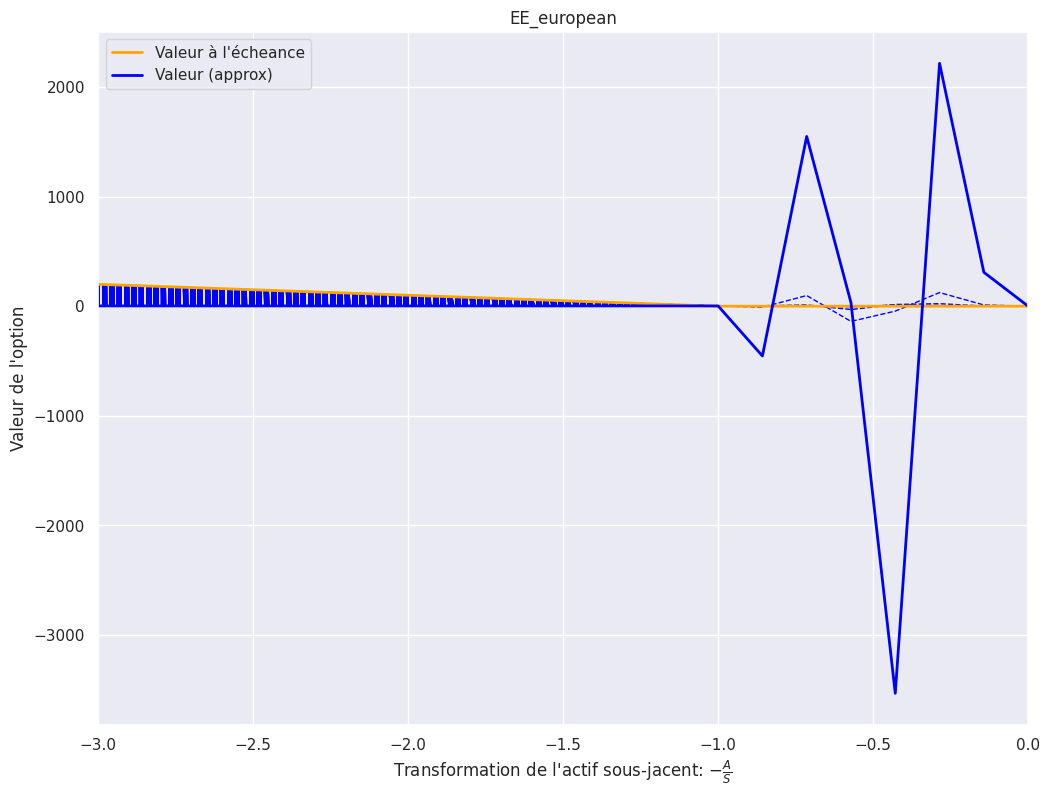

In [14]:
ee_european()

### Sub-classes of LinearizedAmerican.

In [95]:
class EEAmerican(LinearizedAmerican):

    def mat_A(self, coeff):
        A1 = - 1 / (2.*self.h*self.h) * np.diag(np.power(self.sigma*self.x, 2)).dot(
            np.eye(self.N, k=-1) - 2. * np.eye(self.N) + np.eye(self.N, k=1))
        A1[N-1, N-2] = 2*A1[N-1, N-2]  # Condition de Neumann à droite
        A2 = 1 / self.h * \
            np.diag(coeff).dot(-np.eye(self.N) + np.eye(self.N, k=+1))
        A = A1 + A2

        return A

    def mat_B(self, coeff) -> np.ndarray:
        B = np.eye(self.N) - self.k * self.mat_A(coeff)
        return B

In [96]:
ee_american = EEAmerican(K=K,
                         T=T,
                         r=r,
                         sigma=sigma,
                         N=N,
                         J=J,
                         x_min=-x_,
                         x_=x_,
                         g=g,
                         name_g='put',
                         name_method='EE_american',
                         path_to_dir_fig='/git/coding/programming/python_scripts/pde/dir_figs_new/s_0'
                         )

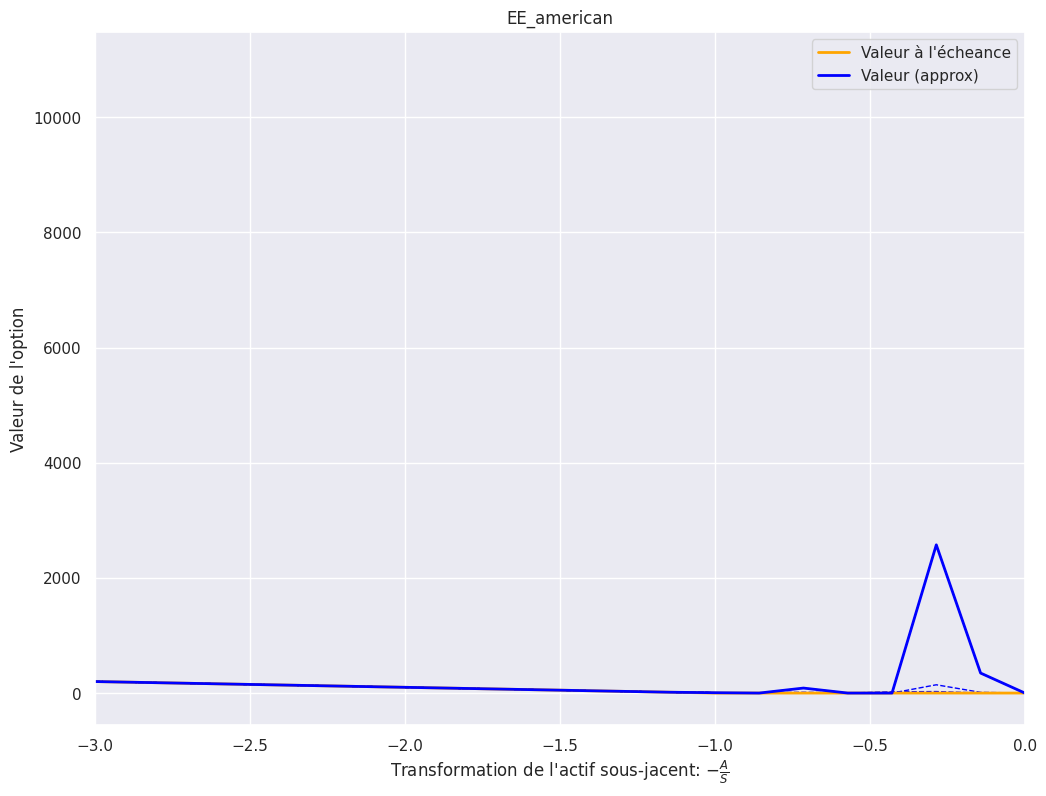

In [97]:
ee_american()

# Euler Implicite European.

In [16]:
class EIEuropean(Linearized):
    def step(self, B, Uj, U0) -> None:
        return np.linalg.solve(B, Uj)

    def mat_A(self, coeff) -> np.ndarray:
        A1 = - 1 / (2.*self.h*self.h) * np.diag(np.power(self.sigma*self.x, 2)).dot(
            np.eye(self.N, k=-1) - 2. * np.eye(self.N) + np.eye(self.N, k=1))
        A2 = np.zeros((self.N, self.N))
        for i in range(len(coeff)-1):
            if coeff[i] < 0:
                A2[i, i] = -coeff[i]
                A2[i, i+1] = coeff[i]
            else:
                A2[i, i] = coeff[i]
                A2[i, i-1] = -coeff[i]
        A1[N-1, N-2] = 2*A1[N-1, N-2]  # Condition de Neumann à droite
        A = A1 + (1./self.h)*A2
        return A

    def mat_B(self, coeff) -> np.ndarray:
        B = np.eye(self.N) + self.k * self.mat_A(coeff)
        return B

In [17]:
ei_european = EIEuropean(K=K,
                         T=T,
                         r=r,
                         sigma=sigma,
                         N=N,
                         J=J,
                         x_min=-x_,
                         x_=x_,
                         g=g,
                         name_g='put',
                         name_method='EI_European',
                         path_to_dir_fig='/git/coding/programming/python_scripts/pde/dir_figs_new/zoom_s_0'
                         )

2.8507497735164975

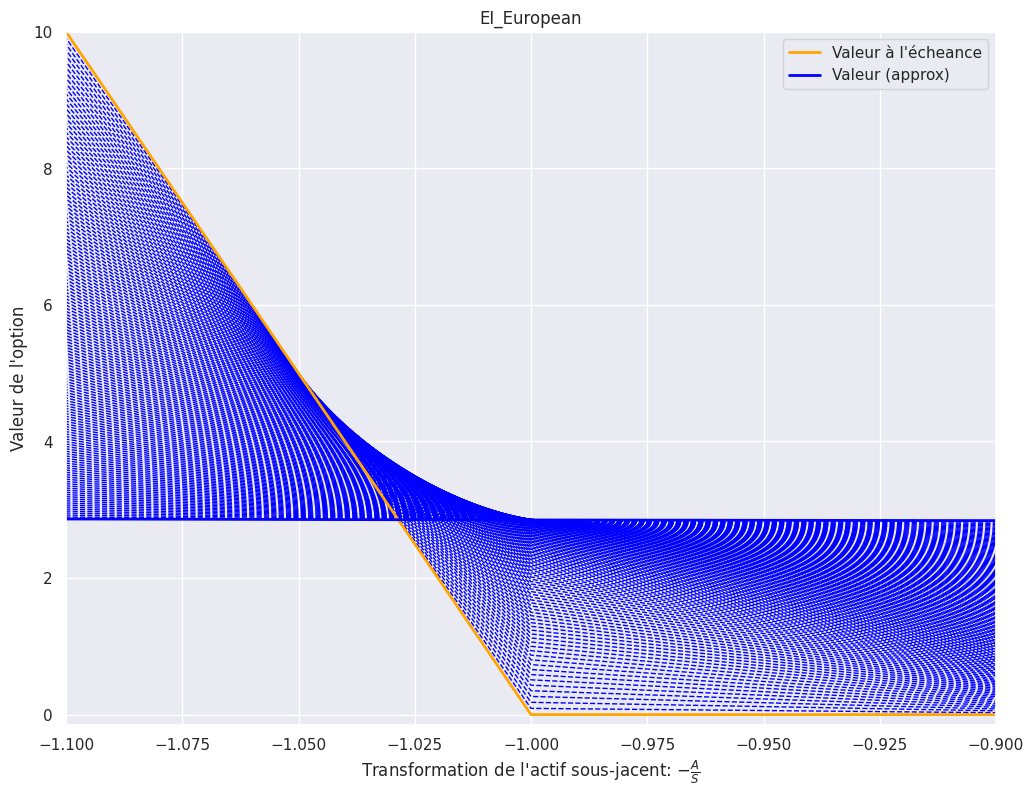

In [18]:
ei_european()

# Euler Implicite Splitting American.

In [19]:
class EISplittingAmerican(Linearized):

    def step(self, B, Uj, U0) -> None:
        return np.maximum(np.linalg.solve(B, Uj), U0)

    def mat_A(self, coeff) -> np.ndarray:
        A1 = - 1 / (2.*self.h*self.h) * np.diag(np.power(self.sigma*self.x, 2)).dot(
            np.eye(self.N, k=-1) - 2. * np.eye(self.N) + np.eye(self.N, k=1))
        A2 = np.zeros((self.N, self.N))
        for i in range(len(coeff)-1):
            if coeff[i] < 0:
                A2[i, i] = -coeff[i]
                A2[i, i+1] = coeff[i]
            else:
                A2[i, i] = coeff[i]
                A2[i, i-1] = -coeff[i]
        A1[N-1, N-2] = 2*A1[N-1, N-2]  # Condition de Neumann à droite
        A = A1 + (1./self.h)*A2
        return A

    def mat_B(self, coeff) -> np.ndarray:
        B = np.eye(self.N) + self.k * self.mat_A(coeff)
        return B

In [20]:
ei_american = EISplittingAmerican(K=K,
                                  T=T,
                                  r=r,
                                  sigma=sigma,
                                  N=N,
                                  J=J,
                                  x_min=-x_,
                                  x_=x_,
                                  g=g,
                                  name_g='put',
                                  name_method='EI_american',
                                  path_to_dir_fig='/git/coding/programming/python_scripts/pde/dir_figs_new/zoom_s_0'
                                  )

6.6670942873417225

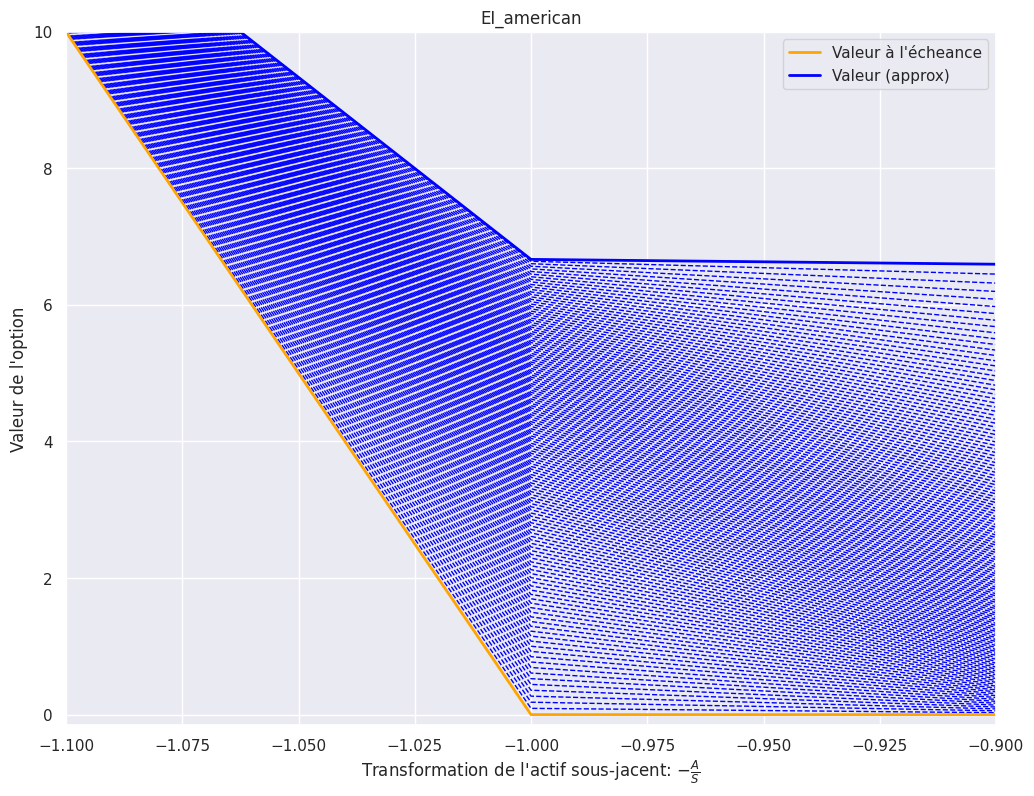

In [21]:
ei_american()

# Howard American.

In [22]:
class EIHowardAmerican(Linearized):

    @staticmethod
    def howard(B: np.ndarray, x0: np.ndarray, b: np.ndarray, G: np.ndarray) -> np.ndarray:
        N = x0.size

        alphaOld = np.full(x0.shape, False)
        alphaNew = np.full(x0.shape, True)

        n = 0

        # convergence si alpha ne change pas

        while not np.array_equal(alphaOld, alphaNew):

            alphaOld = alphaNew

            temp1 = B.dot(x0)-b
            temp2 = x0-G

            # calcul de alpha
            alphaNew = temp1 < temp2
            # alpha sous forme matricielle pour exploiter des commandes de numpy (pas necessaire)
            AlphaNew = np.tile(alphaNew, (N, 1)).transpose()

            # creation du systeme lineaire pour l'etape de l'algo
            B_alpha = np.where(AlphaNew, B, np.eye(N))
            b_alpha = np.where(alphaNew, b, G)

            x0 = np.linalg.solve(B_alpha, b_alpha)

            n = n+1

        # affiche combien d'iteration pour chaque pas
        print(n)
        return x0

    def step(self, B, Uj, U0) -> None:
        return self.howard(B, Uj, Uj, U0)

    def mat_A(self, coeff) -> np.ndarray:
        A1 = - 1 / (2.*self.h*self.h) * np.diag(np.power(self.sigma*self.x, 2)).dot(
            np.eye(self.N, k=-1) - 2. * np.eye(self.N) + np.eye(self.N, k=1))
        A2 = np.zeros((self.N, self.N))
        for i in range(len(coeff)-1):
            if coeff[i] < 0:
                A2[i, i] = -coeff[i]
                A2[i, i+1] = coeff[i]
            else:
                A2[i, i] = coeff[i]
                A2[i, i-1] = -coeff[i]
        A1[N-1, N-2] = 2*A1[N-1, N-2]  # Condition de Neumann à droite
        A = A1 + (1./self.h)*A2
        return A

    def mat_B(self, coeff) -> np.ndarray:
        B = np.eye(self.N) + self.k * self.mat_A(coeff)
        return B

In [23]:
ei_howard = EIHowardAmerican(K=K,
                             T=T,
                             r=r,
                             sigma=sigma,
                             N=N,
                             J=J,
                             x_min=-x_,
                             x_=x_,
                             g=g,
                             name_g='put',
                             name_method='EIH_american',
                             path_to_dir_fig='/git/coding/programming/python_scripts/pde/dir_figs_new/zoom_s_0'
                             )

43
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


6.780639981350918

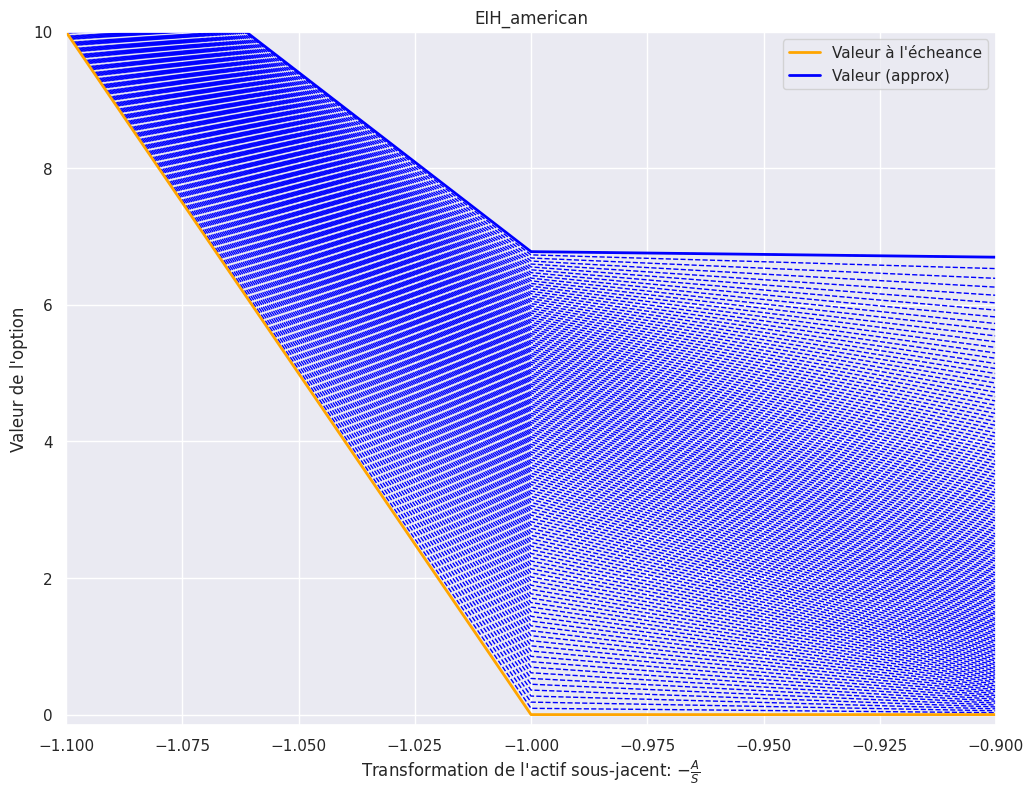

In [24]:
ei_howard()

# Price as a function of the initial price of the underlying.

In [25]:
def option_price_howard(s_0: List[float], path_to_fig: str):

    option_prices = []

    for price in s_0:
        ei_howard = EIHowardAmerican(K=K,
                                     T=T,
                                     r=r,
                                     sigma=sigma,
                                     N=N,
                                     J=J,
                                     x_min=-x_,
                                     x_=x_,
                                     g=g,
                                     name_g='put',
                                     name_method='EIH_american',
                                     path_to_dir_fig='/git/coding/programming/python_scripts/pde/dir_figs_new/s_0',
                                     s_0=price
                                     )
        option_price = ei_howard(plot=False)
        option_prices.append(option_price)

    price, = plt.plot(s_0, option_prices,  color='blue',
                      linestyle='solid', linewidth=2)

    plt.xlabel("Valeur initiale du sous-jacent")
    plt.ylabel("Valeur de l'option")

    # plt.xlim((-3. ,0.))
    # plt.ylim((0. ,500.))

    plt.legend([price], ["Valeur de l'option par la méthode de Howard"])

    plt.title('Valeur de l\'option en fonction du prix initial du sous-jacent')
    plt.savefig(path_to_fig + '/' + str(s_0[0]) + '.png')

43
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
43
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

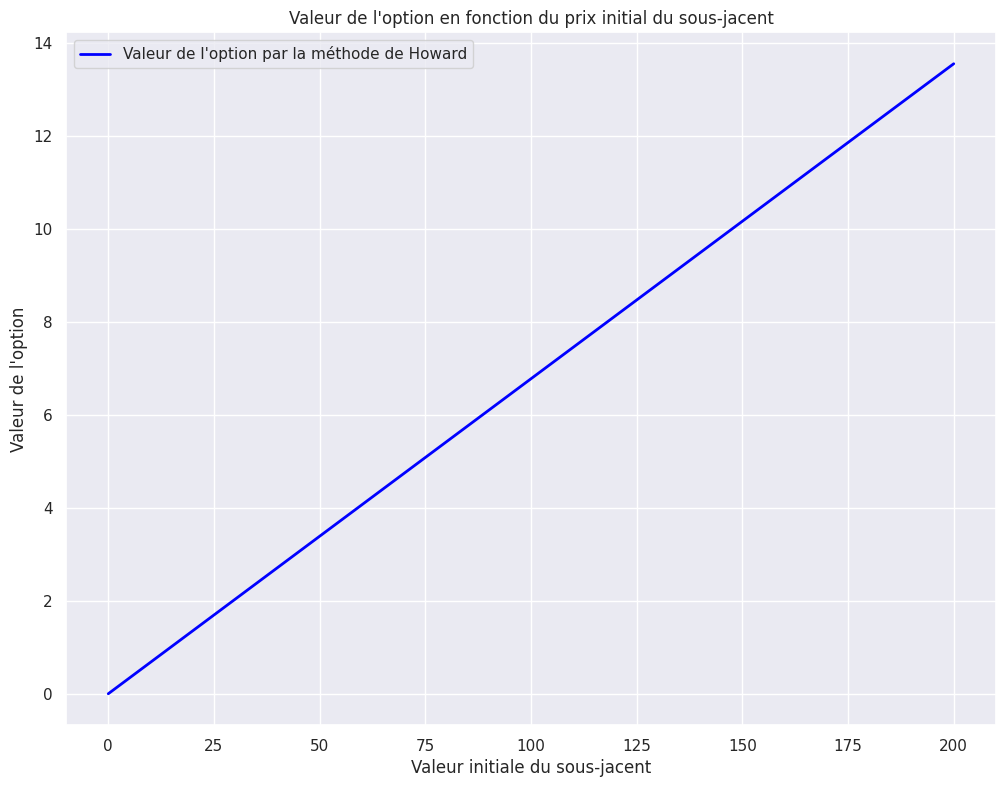

In [28]:
option_price_howard(s_0=np.linspace(0, 200, 20),
                    path_to_fig='/git/coding/programming/python_scripts/pde/dir_figs_new/option_price_fun_s_0',
                    )